## Assignment 2

# 1. Summary

In this Assignment, we elected to develop three seperate Deep Learning Classifiers, for the purpose of identifying greyscale handwritten letters and numbers. We employed 3 models to achieve this:

1. Convolutional Neural Network

2. ????

3. ?????

# 2. Dataset description and Overview
The dataset used for this assignment is a sample from [EMNIST handwritten character dataset - ByClass](https://www.nist.gov/itl/products-and-services/emnist-dataset), a collection of 814,255+ 28 by 28 images with character labels. This smaller sample set can be downloaded from the Google Drive link provided in the assignment specification. The dataset consists of 120000 amount images, of which 100,000 is split into a test set, which was further divided into a validation set after pre-processing, and a testing set of 20,000.

EMNIST - is an Extension of the classical MNIST dataset, hense the name - EMNIST.

Data Samples are catagorised into 62 classes that are unbalanced (see class distribution figure below)

- 0-9: Digits from 0-9

- 10-36: Capital Letters

- 37 - 62: Lowercase Letters

Below are visual examples of the dataset, showcasing a small number from each of the 3 categories.

In [1]:
!pip install keras==3.4.1
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:

import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
import sklearn
import time
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight

#from google.colab import drive
#drive.mount('/content/drive')

2024-10-12 10:29:37.106527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-12 10:29:37.249162: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-12 10:29:37.289697: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-12 10:29:37.576398: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-12 10:29:38.686571: W tensorflow/compiler/tf2

In [3]:
import pickle
import os
import sys

print(os.getcwd())

content_path = ''
#content_path = '/content/drive/MyDrive/EMNIST_Byclass_Small2' #if using drive

train_dict = pickle.load(open(os.path.join(content_path, 'emnist_train.pkl'), 'rb'))
test_dict = pickle.load(open(os.path.join(content_path, 'emnist_test.pkl'), 'rb'))

# Extract the images and labels from the dictionaries
train_images = train_dict['data']
train_labels = train_dict['labels']
test_images = test_dict['data']
test_labels = test_dict['labels']
print("Testing images shape:", test_images.shape)
print("Training images shape:", train_images.shape)
print("Training Labels shape:", train_labels.shape)


/home/calvin/COMP4318_ASSN2
Testing images shape: (20000, 28, 28)
Training images shape: (100000, 28, 28)
Training Labels shape: (100000,)


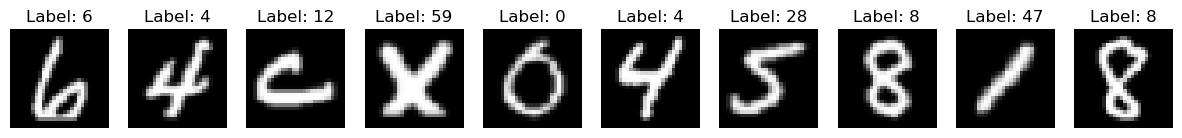

In [4]:
# Number of images to display
num_images = 10

# Create a figure and axes for the grid
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# Iterate through the sample images
for i in range(num_images):
  # Select a random image
  random_index = np.random.randint(0, len(train_images))
  image = np.rot90(train_images[random_index].reshape(28, 28), k=3)  # Rotate 270 degrees (90 * 3)
  image = np.fliplr(image)  # Flip the image horizontally

  # Display the image
  axes[i].imshow(image, cmap='gray')
  axes[i].axis('off')

  #Add the class label above the image
  axes[i].set_title(f"Label: {train_labels[random_index]}", fontsize=12)

plt.show()


### Distribution

As evidenced below, there is an imbalance in the amount of classes, of which is was essential for us to take into account when training our models.

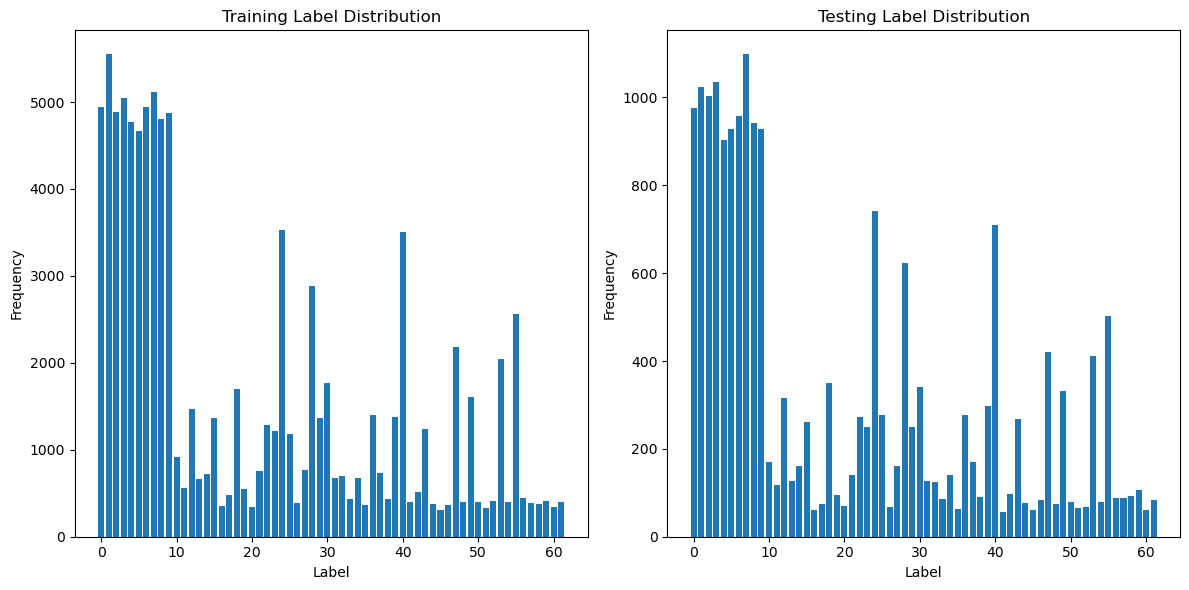

In [5]:
# Calculate the frequency of each label in the training set
train_label_counts = {}
for label in train_labels:
  if label not in train_label_counts:
    train_label_counts[label] = 0
  train_label_counts[label] += 1

# Calculate the frequency of each label in the testing set
test_label_counts = {}
for label in test_labels:
  if label not in test_label_counts:
    test_label_counts[label] = 0
  test_label_counts[label] += 1


# Plot the histogram of training labels
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(train_label_counts.keys(), train_label_counts.values())
plt.title('Training Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')

# Plot the histogram of testing labels
plt.subplot(1, 2, 2)
plt.bar(test_label_counts.keys(), test_label_counts.values())
plt.title('Testing Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


# 3. Data Preparation

Requred data is provided in a .zip file, which is to be unzipped and then placed into the project folder.

- `emnist_test.pkl`: Contains a Dictionary of 20,000 Testing Images and Labels

- `emnist_train.pkl`: Contains a Dictionary of 100,000 Training Images and Labels


## 3.1 Merging Classes

Due to the similarities of Uppercase and Lowercase letters, as [suggested](https://arxiv.org/pdf/1702.05373v1) by the creators of the dataset specific images will be merged, for example lowercase 'k' is similar to uppercase "K"


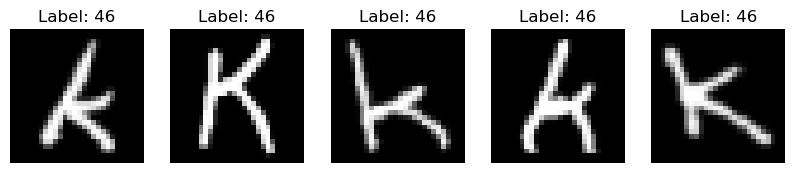

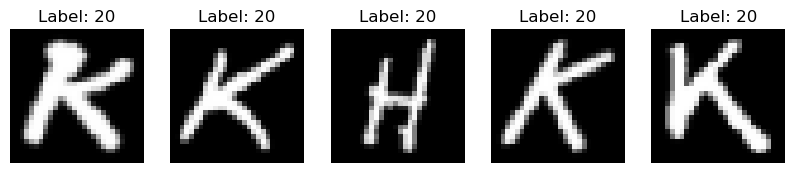

In [6]:
def display_images_by_label(images, labels, target_label, num_samples=5):
    # Find the indices of images with the target label
    indices = np.where(labels == target_label)[0]

    # Display a few images with the specified label
    if len(indices) == 0:
        print(f"No images found for label {target_label}")
        return

    # Limit to the specified number of samples
    indices = indices[:num_samples]

    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        # Rotate 180 degrees (k=2) and then flip horizontally
        rotated_image = np.fliplr(np.rot90(images[idx].reshape(28, 28), k=3))

        # Display the rotated and flipped image
        plt.imshow(rotated_image, cmap='gray')
        plt.title(f"Label: {labels[idx]}")
        plt.axis('off')
    plt.show()

# Example usage:
# For example, 38 is 'c' and 12 is 'C' in the original EMNIST ByClass labels.
display_images_by_label(train_images, train_labels, target_label=46, num_samples=5)  # Display lowercase 'c'
display_images_by_label(train_images, train_labels, target_label=20, num_samples=5)  # Display uppercase 'C'

From the above figure we can also see that the dataset it not perfect, the 3rd image on the bottom set is clearly an H. As such it is imperative that we incorporate means of mitigating other potential mislabels in the dataset, such as incorporating label smoothing (assigning probabilities to predictions - done via softmax), or data augmentation, as well as normalisation.

In [7]:
merge_dictionary = {
        38: 12,  # 'c' -> 'C'
        44: 18,  # 'i' -> 'I'
        45: 19,  # 'j' -> 'J'
        46: 20,  # 'k' -> 'K'
        47: 21,  # 'l' -> 'L'
        48: 22,  # 'm' -> 'M'
        50: 24,  # 'o' -> 'O'
        51: 25,  # 'p' -> 'P'
        54: 28,  # 's' -> 'S'
        56: 30,  # 'u' -> 'U'
        57: 31,  # 'v' -> 'V'
        58: 32,  # 'w' -> 'W'
        59: 33,  # 'x' -> 'X'
        60: 34,  # 'y' -> 'Y'
        61: 35   # 'z' -> 'Z'
    }

def merge_labels(labels, merge_dictionary):
    merged_labels = np.copy(labels)
    for old_label, new_label in merge_dictionary.items():
        merged_labels[labels == old_label] = new_label
    return merged_labels

#Step 0
# Merge the labels
train_labels = merge_labels(train_labels, merge_dictionary)
test_labels = merge_labels(test_labels, merge_dictionary)
#Print Number of unique labels
print("Number of unique labels in the training set:", len(np.unique(train_labels)))
print("Number of unique labels in the testing set:", len(np.unique(test_labels)))

Number of unique labels in the training set: 47
Number of unique labels in the testing set: 47


In [8]:
# Full list of labels for the merged EMNIST dataset
label_mapping = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',  # Digits (0-9)
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',  # Letters (10-19)
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',  # Letters (20-29)
    'U', 'V', 'W', 'X', 'Y', 'Z',                      # Letters (30-35)
    'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r',  # Lowercase that aren't merged (36-45)
    't'                                                 # Remaining lowercase letter (46)
]
def map_labels_to_characters(label_indices):
    return [label_mapping[index] for index in label_indices]

sample_labels = [0, 12, 35, 46]
mapped_characters = map_labels_to_characters(sample_labels)
print("Mapped characters:", mapped_characters)

Mapped characters: ['0', 'C', 'Z', 't']


## 3.2 Further Preprocessing

The below cell is where key steps of the preprocessing occurs, in order

1. Label Encoding: Done to transform the labels into a meaningful format for our classifiers to work with

2. Normalisation: Done to improve model convergence as well as training stability, provides consistent input data  (for more information return to report)

3. Reshaping to ensure data is in appropriate format

4. Creation of a validation set

5. Data Augmentation step - due to aformentioned reasons as well as unbalanced class distributions

6. Computation of class weights for training, to also mitigate class imbalance

7. Type conversion

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
import tensorflow as tf

# Step 1: Label Encoding
label_encoder = LabelEncoder()
label_encoder.fit(train_labels)
train_labels = label_encoder.transform(train_labels)
test_labels = label_encoder.transform(test_labels)

# Step 2: Normalize the pixel values (0-255) to the range [0, 1]
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Step 3: Reshape the images for model input
N_train = train_images.shape[0]  # Number of training images
N_test = test_images.shape[0]    # Number of testing images

# Reshape the images to (N, 28, 28, 1)
train_images = train_images.reshape(N_train, 28, 28, 1)
test_images = test_images.reshape(N_test, 28, 28, 1)

# Step 4: Validation set split
X_train, X_valid, y_train, y_valid = train_test_split(train_images, train_labels, train_size=0.9, random_state=42)

# Step 5: Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rotation_range=10,       # Randomly rotate images by up to 10 degrees
    width_shift_range=0.1,   # Randomly shift images horizontally by up to 10% of width
    height_shift_range=0.1,  # Randomly shift images vertically by up to 10% of height
    zoom_range=0.1           # Randomly zoom into images by up to 10%
)

# No augmentation for validation data, just rescaling
valid_datagen = ImageDataGenerator()

# Step 6: Fit the data generator on the training images (optional)
train_datagen.fit(X_train)

# Step 7: Class Rebalancing
# Compute class weights to account for class imbalance
classes = np.unique(y_train)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Step 8: Convert data to appropriate types
X_train = X_train.astype('float32')
y_train = y_train.astype('int64')
X_valid = X_valid.astype('float32')
y_valid = y_valid.astype('int64')

# Print summary of preprocessing steps
print("Train images shape (after reshaping):", X_train.shape)
print("Validation images shape:", X_valid.shape)
print("Test images shape (after reshaping):", test_images.shape)
print("Class weights for balancing:", class_weights_dict)

Train images shape (after reshaping): (90000, 28, 28, 1)
Validation images shape: (10000, 28, 28, 1)
Test images shape (after reshaping): (20000, 28, 28, 1)
Class weights for balancing: {0: 0.42954096388992297, 1: 0.38251969976453787, 2: 0.4321583428168081, 3: 0.421968624288514, 4: 0.45098766298193044, 5: 0.4541967782308531, 6: 0.43235349221523517, 7: 0.414120591916366, 8: 0.44357044637972587, 9: 0.43372448856654056, 10: 2.33523611831863, 11: 3.732736095558044, 12: 1.1283993028999861, 13: 3.223726627981947, 14: 2.9459901800327333, 15: 1.5695849319846529, 16: 5.946874587022598, 17: 4.474050507059057, 18: 1.0234599770290094, 19: 2.486874827300359, 20: 3.0638297872340425, 21: 0.7206976353109811, 22: 1.2673021952490249, 23: 1.736077621959453, 24: 0.5440038684719536, 25: 1.435452486522696, 26: 5.733214422219391, 27: 2.7711919204360007, 28: 0.6502185456778529, 29: 1.5442690459849004, 30: 0.9603277918862972, 31: 2.015677491601344, 32: 1.9539730785931393, 33: 2.5772457833395377, 34: 2.11824515

## 4. Model 1 - CNN
Defining Initial CNN to Expound upon

In [10]:
# Define the model
#from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import ReLU
from tensorflow.keras import layers

keras.backend.clear_session()

data_augmentation = keras.Sequential([
    layers.RandomRotation(0.1),        # Randomly rotate images by up to 10 degrees
    layers.RandomTranslation(0.1, 0.1),# Randomly shift images horizontally and vertically by up to 10%
    layers.RandomZoom(0.1),            # Randomly zoom into images by up to 10%
    layers.RandomFlip("horizontal"),   # Optionally, flip images horizontally
])

model = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),  # Input shape for EMNIST data

    #data_augmentation,

    # First Conv Block
    keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Second Conv Block
    keras.layers.Conv2D(48, kernel_size=(3, 3), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Third Conv Block
    keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),

    # Fourth Conv Block
    keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Flatten Layer
    keras.layers.Flatten(),

    # Fully Connected Layers
    keras.layers.Dense(128),  # No activation here, add as a separate layer
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(len(classes), activation="softmax"),  # Output layer for classification
])

model.summary()

I0000 00:00:1728689380.836028  516096 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728689380.836166  516096 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-12 10:29:41.085694: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 48)     │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 14, 14, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 288,031 (1.10 MB)

 Trainable params: 286,975 (1.09 MB)

 Non-trainable params: 1,056 (4.12 KB)

As evident above, this model is a CNN with four convolutional layers, two dense layers, utilising ReLu as the activation function, as well as batch normalisation and dropout. Adam is the optimiser used, and an early stopping routine is utilised to save compute resources in the event that the model's performance stagnates during training, and to also prevent overfitting.

### 4.2 Fitting initial model

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Define EarlyStopping callback used GEN AI
early_stopping = EarlyStopping(
    monitor='val_loss',        # Metric to monitor
    patience=5,                # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored metric
    verbose=1                  # Verbosity mode
)

# Compile model with adjusted learning rate for Adam optimizer
learning_rate = 0.0005  # Decreasing the learning rate for better convergence
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Set batch size and number of epochs
batch_size = 128
epochs = 40

# Fit the model
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs, validation_data=valid_datagen.flow(X_valid, y_valid, batch_size=batch_size),
                    class_weight=class_weights_dict, callbacks = [early_stopping])




Epoch 1/40


/home/calvin/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 ━━━━━━━━━━━━━━━━━━━━ 36s 47ms/step - accuracy: 0.3949 - loss: 2.3824 - val_accuracy: 0.7699 - val_loss: 0.7249
Epoch 2/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 35s 50ms/step - accuracy: 0.7501 - loss: 0.7547 - val_accuracy: 0.7999 - val_loss: 0.5725
Epoch 3/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - accuracy: 0.7853 - loss: 0.5797 - val_accuracy: 0.8539 - val_loss: 0.4093
Epoch 4/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - accuracy: 0.8063 - loss: 0.5195 - val_accuracy: 0.8577 - val_loss: 0.3883
Epoch 5/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - accuracy: 0.8151 - loss: 0.4737 - val_accuracy: 0.8610 - val_loss: 0.3740
Epoch 6/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - accuracy: 0.8255 - loss: 0.4569 - val_accuracy: 0.8504 - val_loss: 0.4017
Epoch 7/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.8297 - loss: 0.4282 - val_accuracy: 0.8328 - val_loss: 0.4511
Epoch 8/40
704/704 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - accuracy: 0.8319 - loss: 0.4151 - val_accurac

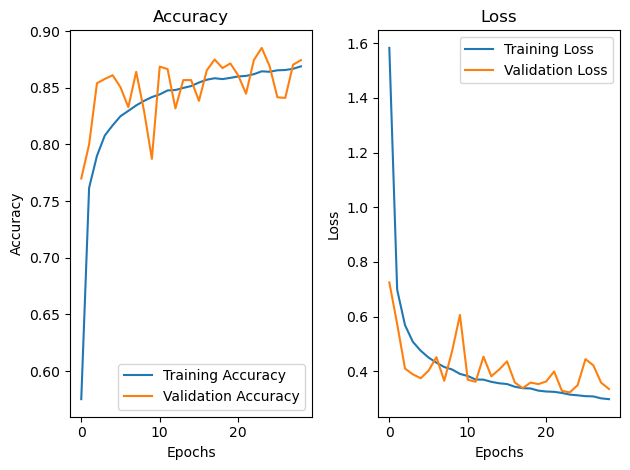

In [12]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



### 4.3 Evaluating Initial Model

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8818 - loss: 0.3242
Test Loss: 0.32427167892456055
Test Accuracy: 0.8826500177383423
Model evaluation time: 1.3702 seconds
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Inference time for predictions: 1.8808 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.73      0.71       976
           1       0.66      0.88      0.75      1023
           2       0.96      0.93      0.95      1003
           3       0.99      0.99      0.99      1035
           4       0.99      0.95      0.97       903
           5       0.94      0.94      0.94       928
           6       0.99      0.91      0.95       959
           7       0.99      0.99      0.99      1098
           8       0.99      0.94      0.96       941
           9       0.94      0.89      0.91       929
           A       0.92      0.98      0.95       170
           B       0.93      0.98      0.95       118
       

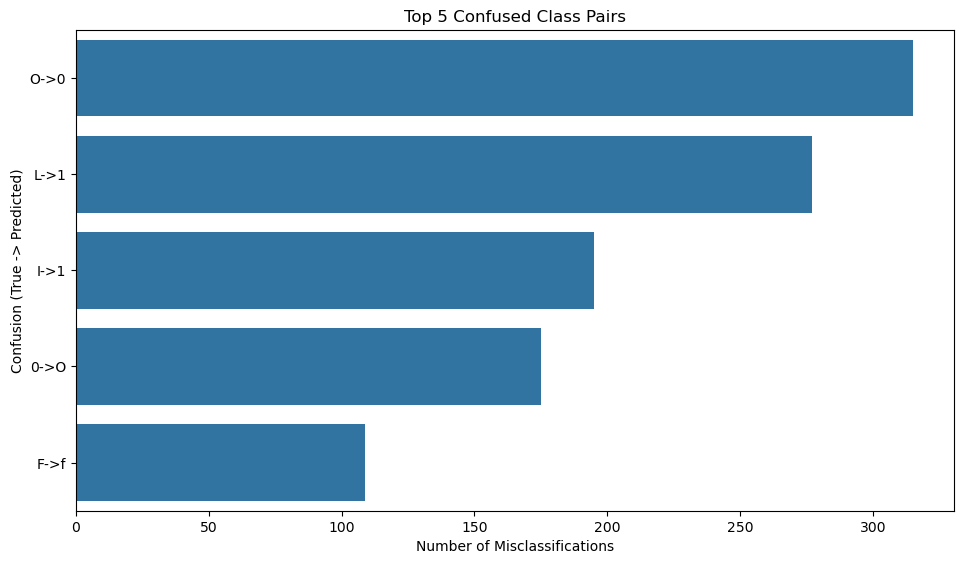




Visualizing misclassified examples for top confused pairs:


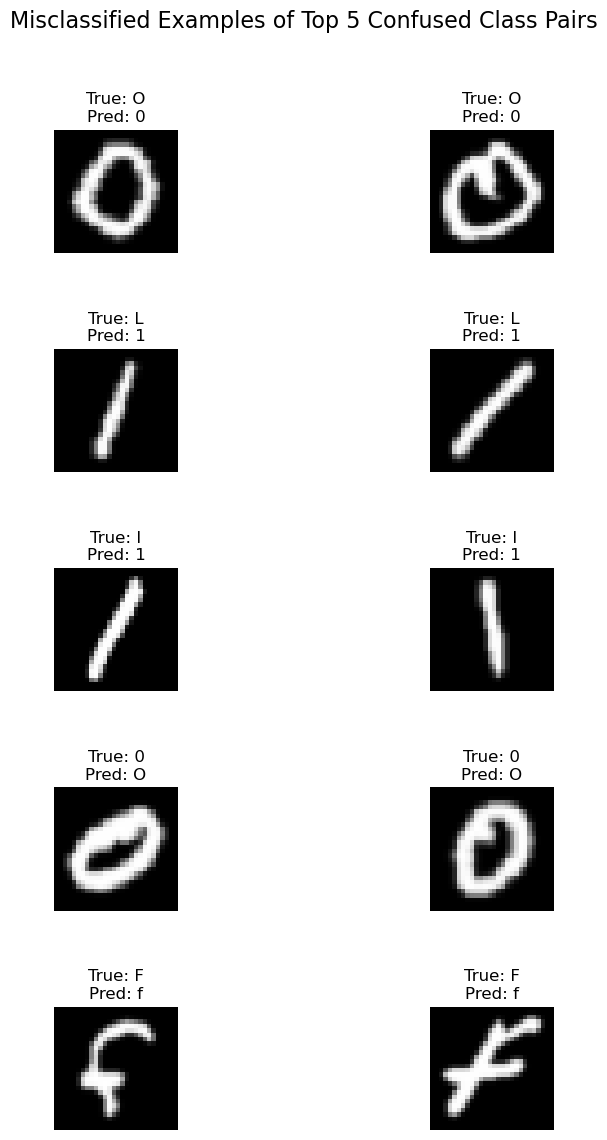




Plotting per-class accuracy (sorted):


/tmp/ipykernel_516096/2706215204.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_accuracy, y=sorted_labels, palette='coolwarm')


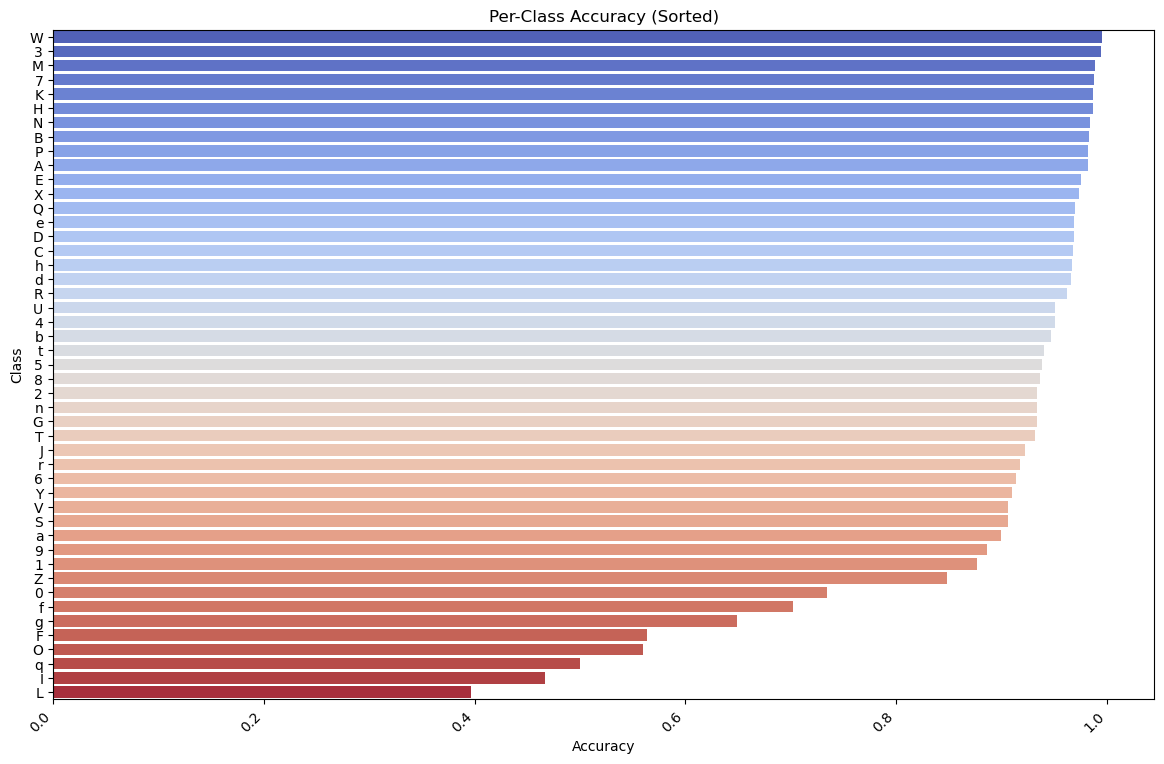

In [13]:
import time
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Evaluate the model on the test set
start_time = time.time()  # Start the timer for model evaluation
test_loss, test_accuracy = model.evaluate(test_images, test_labels, batch_size=64)
end_time = time.time()  # End the timer
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Model evaluation time: {end_time - start_time:.4f} seconds")

# Step 2: Measure inference time for predictions
start_time = time.time()  # Start the timer for prediction inference
predictions = model.predict(test_images)
end_time = time.time()  # End the timer
predicted_labels = np.argmax(predictions, axis=1)
print(f"Inference time for predictions: {end_time - start_time:.4f} seconds")

# Step 3: Generate a classification report using the mapped labels
mapped_test_labels = [label_mapping[label] for label in test_labels]
mapped_predicted_labels = [label_mapping[label] for label in predicted_labels]

print("\nClassification Report:")
print(classification_report(mapped_test_labels, mapped_predicted_labels, target_names=label_mapping))

# Step 4: Create confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Step 5: Find the top 5 most confused class pairs
confusion_pairs = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j:
            confusion_pairs.append((i, j, cm[i, j]))

confusion_pairs.sort(key=lambda x: x[2], reverse=True)
top_5_confused = confusion_pairs[:5]

# Step 6: Bar chart for top 5 confused pairs
print("\nBar chart for the top 5 confused class pairs:")
top_true_classes = [label_mapping[true_class] for true_class, _, _ in top_5_confused]
top_pred_classes = [label_mapping[pred_class] for _, pred_class, _ in top_5_confused]
top_confusion_counts = [count for _, _, count in top_5_confused]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_confusion_counts, y=[f"{true}->{pred}" for true, pred in zip(top_true_classes, top_pred_classes)], legend=False)
plt.xlabel("Number of Misclassifications")
plt.ylabel("Confusion (True -> Predicted)")
plt.title("Top 5 Confused Class Pairs")
plt.tight_layout(pad=2.0)  # Add spacing between charts
plt.show()

print("\n\n")  # Add space between plots

# Step 7: Visualize misclassified examples for each pair
print("Visualizing misclassified examples for top confused pairs:")
num_examples = 2  # Number of examples to show for each confused pair
fig, axes = plt.subplots(len(top_5_confused), num_examples, figsize=(10, 12))  # Adjusted figure size
fig.suptitle("Misclassified Examples of Top 5 Confused Class Pairs", fontsize=16)

for idx, (true_class, pred_class, count) in enumerate(top_5_confused):
    true_label = label_mapping[true_class]
    pred_label = label_mapping[pred_class]

    # Find examples of this confusion
    confused_indices = np.where((test_labels == true_class) & (predicted_labels == pred_class))[0]

    # Plot examples with rotation and flipping
    for example_idx in range(min(len(confused_indices), num_examples)):
        confused_example = test_images[confused_indices[example_idx]].reshape(28, 28)

        # Rotate the image 90 degrees and flip horizontally
        rotated_flipped_example = np.fliplr(np.rot90(confused_example, k=3))

        axes[idx, example_idx].imshow(rotated_flipped_example, cmap='gray')
        axes[idx, example_idx].set_title(f"True: {true_label}\nPred: {pred_label}")
        axes[idx, example_idx].axis('off')

plt.tight_layout(pad=4.0)
plt.subplots_adjust(top=0.88)
plt.show()

print("\n\n")  # Add space between plots

# Step 8: Additional Evaluation - Sorted Per-Class Accuracy Plot
# Calculate per-class accuracy
print("Plotting per-class accuracy (sorted):")
per_class_accuracy = np.diag(cm) / np.sum(cm, axis=1)

# Sort the per-class accuracy and corresponding labels
sorted_indices = np.argsort(per_class_accuracy)[::-1]  # Sort in descending order
sorted_accuracy = per_class_accuracy[sorted_indices]
sorted_labels = [label_mapping[i] for i in sorted_indices]

# Plot sorted per-class accuracy
plt.figure(figsize=(12, 8))  # Larger figure for readability
sns.barplot(x=sorted_accuracy, y=sorted_labels, palette='coolwarm')
plt.xlabel('Accuracy')
plt.ylabel('Class')
plt.title('Per-Class Accuracy (Sorted)')

# Rotate the class names for readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout(pad=2.0)
plt.show()


All things considered, this initial model perfoms pretty decently on the unseen data. Look at the examples yourself and decide whether you would have honestly guessed the correct label

## 4.4 Setting up Hyperparameter Tuning

## Hyperparameters for CNN Model Tuning

CNN models have a wide range of hyperparameters that we can attempt to tune to optimize performance. Below is a breif description of the hyperparameters we have elected to tune, note that this is not the full exhaustive list due to the issue of computation time.

### 1. **Convolutional Layer Parameters**
- **Number of Convolution Layers:** the number of convolution layers in the network, more allows for richer feature extraction
- **Filters/Feature Maps:** List defining the number of filter in each layer, filter size increases however the options range from a large increase as well a a static number to capture more complex feautres
- **Kernel Size:** The size of the filter, which is a small square matrix
- **Strides:** This hyperparameter alters the strides for the convolution layer or the pooling layer, i.e the steps taken by the filter layers or pooling layers
- **Pooling Frequency**: Alters how often we add a pooling layer i.e after each convolution layer or not
- **Pool Size:** Size of the pooling window to alter the reduction in dimension of inputs

### 2. **Dense Layer Parameters**
- **Dense Layers**: This parameter alters the number of dense layers after our convolutional pooling blocks
- **Dense Neurons**: This controls the number of neurons in each of the aforementioned dense layers

### 3. **Dropout Parameters**
- **Dropout Rates**: Dropout rates attempt to mitigate overfitting, this set of parameters selects a set of 3 rates randomly and applys them to the dense layers for regularisation.

### 4. **Activation Functions**
   - **activation**: The activation function applied after each layer, relu or leaky relu will be tested.

### 5. **Input & Output**
   - **Input shape and Number of Classes:** This is static but added as a hyperparameter for consistency

### 6. **Optimizer and Learning Rate**
   - **Optimizesr**: Alters the optimisation algorithm used for backpropagation, Adam and rmsprop are tested.
   - **learning_rate**: Controls how quickly the model learns, different rates are tested to attempt to escape local minima.


### 7. **Loss Function**
   - **Loss funciton:** loss functin used it categorical cross entropy and will stay static due to nature of inputs.

Tuning these hyperparameters will allow us to find the best structure for achieving a high accuracy.

In [14]:
!pip install --upgrade keras-tuner

Defaulting to user installation because normal site-packages is not writeable


In [15]:
# https://github.com/keras-team/keras-tuner/issues/128
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your custom hypermodel class
class MyHyperModel(kt.HyperModel):
    def __init__(self):
        super().__init__()
        self.hp_log = []

    def build(self, hp):
        self.hp_log = []  # Reset the log for each build
        input_shape = (28, 28, 1)
        num_classes = 47

        model = keras.Sequential()
        model.add(keras.Input(shape=input_shape))

        # Data augmentation layer
        data_augmentation = keras.Sequential([
            layers.RandomRotation(0.1),        # Randomly rotate images by up to 10 degrees
            layers.RandomTranslation(0.1, 0.1),# Randomly shift images horizontally and vertically by up to 10%
            layers.RandomZoom(0.1),            # Randomly zoom into images by up to 10%
            layers.RandomFlip("horizontal"),   # Optionally, flip images horizontally
        ])

        #model.add(data_augmentation)  # Add data augmentation to the model

        filter_grids = [
            [32, 48, 64, 128],
            [32, 64, 128, 256],
            [64, 64, 64, 64],
            [128, 64, 32, 32],
        ]

        selected_grid_idx = self._log_hp(hp.Choice, 'filter_grid', [0, 1, 2, 3])
        filters = filter_grids[selected_grid_idx]

        conv_layers = self._log_hp(hp.Int, 'conv_layers', min_value=2, max_value=5, step=1)
        kernel_size_options = [(3, 3), (5, 5)]
        selected_kernel_size_idx = self._log_hp(hp.Choice, 'kernel_size', [0, 1])
        kernel_size = kernel_size_options[selected_kernel_size_idx]

        conv_strides_options = [(1, 1), (2, 2)]
        selected_conv_strides_idx = self._log_hp(hp.Choice, 'conv_strides', [0, 1])
        conv_strides = conv_strides_options[selected_conv_strides_idx]

        pool_size_options = [(2, 2), (3, 3)]
        selected_pool_size_idx = self._log_hp(hp.Choice, 'pool_size', [0, 1])
        pool_size = pool_size_options[selected_pool_size_idx]

        pool_strides_options = [None, (2, 2)]
        selected_pool_strides_idx = self._log_hp(hp.Choice, 'pool_strides', [0, 1])
        pool_strides = pool_strides_options[selected_pool_strides_idx]

        dense_layers = self._log_hp(hp.Int, 'dense_layers', min_value=1, max_value=3, step=1)
        dense_neurons = self._log_hp(hp.Choice, 'dense_neurons', [64, 128, 256])
        dropout_rate_1 = self._log_hp(hp.Choice, 'dropout_rate_1', [0.0, 0.3, 0.5])
        dropout_rate_2 = self._log_hp(hp.Choice, 'dropout_rate_2', [0.0, 0.2, 0.4])
        dropout_rate_3 = self._log_hp(hp.Choice, 'dropout_rate_3', [0.0, 0.1, 0.3])

        activation = self._log_hp(hp.Choice, 'activation', ['relu', 'leaky_relu'])
        pooling_frequency = self._log_hp(hp.Choice, 'pooling_frequency', [1, 2])

        optimizer_name = self._log_hp(hp.Choice, 'optimizer', ['adam', 'rmsprop'])
        learning_rate = self._log_hp(hp.Choice, 'learning_rate', [0.001, 0.0001])

        for i in range(conv_layers):
            filter_num = filters[i] if i < len(filters) else filters[-1]
            model.add(layers.Conv2D(filter_num, kernel_size=kernel_size,
                                    strides=conv_strides, padding='same'))
            model.add(layers.BatchNormalization())
            model.add(layers.Activation(activation))

            # Get the current input shape before applying pooling
            current_shape = model.output_shape[1:3]  # Get height and width (ignores batch size and channels)
            if (i + 1) % pooling_frequency == 0 and current_shape[0] >= pool_size[0] and current_shape[1] >= pool_size[1]:
                model.add(layers.MaxPooling2D(pool_size=pool_size, strides=pool_strides))

        model.add(layers.Flatten())

        dropout_rates = [dropout_rate_1, dropout_rate_2, dropout_rate_3]
        for i in range(dense_layers):
            model.add(layers.Dense(dense_neurons))
            model.add(layers.BatchNormalization())
            model.add(layers.Activation(activation))
            if i < len(dropout_rates) and dropout_rates[i] > 0:
                model.add(layers.Dropout(dropout_rates[i]))

        model.add(layers.Dense(num_classes, activation="softmax"))

        # Compile the model
        if optimizer_name == 'adam':
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer_name == 'rmsprop':
            optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
        else:
            raise ValueError(f"Unsupported optimizer: {optimizer_name}")

        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        return model

    def _log_hp(self, hp_func, name, *args, **kwargs):
        value = hp_func(name, *args, **kwargs)
        self.hp_log.append({
            'name': name,
            'type': hp_func.__name__,
            'args': args,
            'kwargs': kwargs,
            'value': value
        })
        return value

    def fit(self, hp, model, *args, **kwargs):
        # Log the batch_size hyperparameter
        batch_size = self._log_hp(hp.Choice, "batch_size", [32, 64, 128])
        return model.fit(
            *args,
            batch_size=batch_size,
            **kwargs,
        )

    def get_hp_log(self):
        return self.hp_log




Defining early stopping and setting up random search

In [16]:
import inspect
early_stopping = EarlyStopping(
    monitor='val_loss',        # Metric to monitor
    patience=5,                # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored metric
    verbose=1                  # Verbosity mode
)


hypermodel = MyHyperModel()
tuner = kt.RandomSearch(
    hypermodel,
    objective="val_accuracy",
    max_trials=50,
    executions_per_trial=1,
    overwrite=True,
    directory="kt_search_logs",
    project_name="cnn_hypermodel_tuning",
)

# Print the search space summary
print("Search space summary:")
tuner.search_space_summary(extended=True)

Search space summary:
Search space summary
Default search space size: 15
filter_grid (Choice)
{'default': 0, 'conditions': [], 'values': [0, 1, 2, 3], 'ordered': True}
conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
kernel_size (Choice)
{'default': 0, 'conditions': [], 'values': [0, 1], 'ordered': True}
conv_strides (Choice)
{'default': 0, 'conditions': [], 'values': [0, 1], 'ordered': True}
pool_size (Choice)
{'default': 0, 'conditions': [], 'values': [0, 1], 'ordered': True}
pool_strides (Choice)
{'default': 0, 'conditions': [], 'values': [0, 1], 'ordered': True}
dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
dense_neurons (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
dropout_rate_1 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.3, 0.5], 'ordered': True}
dropout_rate_2 (Choice)
{'default'

Actually performing the search and obtaining the best model

In [17]:
import time

# Start the timer for hyperparameter search
start_time = time.time()

# Perform the hyperparameter search
tuner.search(
    train_datagen.flow(X_train, y_train),
    epochs=20,
    validation_data=valid_datagen.flow(X_valid, y_valid),
    callbacks=[early_stopping]
)

# End the timer for hyperparameter search
end_time = time.time()

# Calculate and print the time taken for the search
search_time = end_time - start_time
print(f"Time taken for hyperparameter search: {search_time:.4f} seconds")

# Get the best hyperparameters after the search
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]


Trial 24 Complete [00h 07m 25s]
val_accuracy: 0.8729000091552734

Best val_accuracy So Far: 0.8970999717712402
Total elapsed time: 10h 16m 48s

Search: Running Trial #25

Value             |Best Value So Far |Hyperparameter
3                 |2                 |filter_grid
2                 |5                 |conv_layers
1                 |0                 |kernel_size
0                 |0                 |conv_strides
0                 |0                 |pool_size
0                 |1                 |pool_strides
2                 |1                 |dense_layers
256               |128               |dense_neurons
0                 |0                 |dropout_rate_1
0                 |0.2               |dropout_rate_2
0.3               |0.3               |dropout_rate_3
relu              |relu              |activation
2                 |2                 |pooling_frequency
rmsprop           |adam              |optimizer
0.001             |0.0001            |learning_rate
64       

 168/2813 ━━━━━━━━━━━━━━━━━━━━ 7:23 168ms/step - accuracy: 0.8307 - loss: 0.4863

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 473s 168ms/step - accuracy: 0.8444 - loss: 0.4545 - val_accuracy: 0.8773 - val_loss: 0.3843
Epoch 3/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 486s 173ms/step - accuracy: 0.8588 - loss: 0.4122 - val_accuracy: 0.8732 - val_loss: 0.3840
Epoch 4/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 484s 172ms/step - accuracy: 0.8671 - loss: 0.3801 - val_accuracy: 0.8802 - val_loss: 0.3790
Epoch 5/20
 351/2813 ━━━━━━━━━━━━━━━━━━━━ 7:05 173ms/step - accuracy: 0.8674 - loss: 0.3724

KeyboardInterrupt: 

In [ ]:
import time

# Iterate through all trials and print details
for trial in tuner.oracle.trials.values():
    print(f"Trial ID: {trial.trial_id}")
    print(f"Hyperparameters: {trial.hyperparameters.values}")
    print(f"Score: {trial.score}\n")

# Start the timer for model evaluation
start_time = time.time()

# Evaluate the best model
test_loss, test_accuracy = best_model.evaluate(valid_datagen.flow(test_images, test_labels, batch_size=best_hps.get('batch_size')))

# End the timer for model evaluation
end_time = time.time()

# Calculate and print the time taken for the evaluation
evaluation_time = end_time - start_time
print(f"Time taken for model evaluation: {evaluation_time:.4f} seconds")

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy}")


Trial ID: 0
Hyperparameters: {'filter_grid': 1, 'conv_layers': 2, 'kernel_size': 0, 'conv_strides': 1, 'pool_size': 1, 'pool_strides': 1, 'dense_layers': 2, 'dense_neurons': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.0, 'dropout_rate_3': 0.0, 'activation': 'relu', 'pooling_frequency': 2, 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32}
Score: 0.8794000148773193

Trial ID: 1
Hyperparameters: {'filter_grid': 3, 'conv_layers': 2, 'kernel_size': 1, 'conv_strides': 1, 'pool_size': 1, 'pool_strides': 1, 'dense_layers': 1, 'dense_neurons': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.4, 'dropout_rate_3': 0.3, 'activation': 'relu', 'pooling_frequency': 1, 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 128}
Score: 0.878000020980835

Trial ID: 2
Hyperparameters: {'filter_grid': 0, 'conv_layers': 4, 'kernel_size': 1, 'conv_strides': 0, 'pool_size': 1, 'pool_strides': 0, 'dense_layers': 3, 'dense_neurons': 256, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.2, 'dropout_

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8881 - loss: 0.3245
Test Loss: 0.33925968408584595
Test Accuracy: 0.888700008392334
Model evaluation time: 1.6707 seconds
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Inference time for predictions: 2.1065 seconds




Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.88      0.73       976
           1       0.62      0.97      0.76      1023
           2       0.96      0.98      0.96      1003
           3       1.00      0.99      0.99      1035
           4       0.96      0.97      0.96       903
           5       0.93      0.94      0.94       928
           6       0.98      0.96      0.97       959
           7       0.99      0.99      0.99      1098
           8       0.97      0.98      0.97       941
           9       0.92      0.97      0.94       929
           A       0.92      0.98      0.95       170
           B       0.89      0.98      0.94       118
     

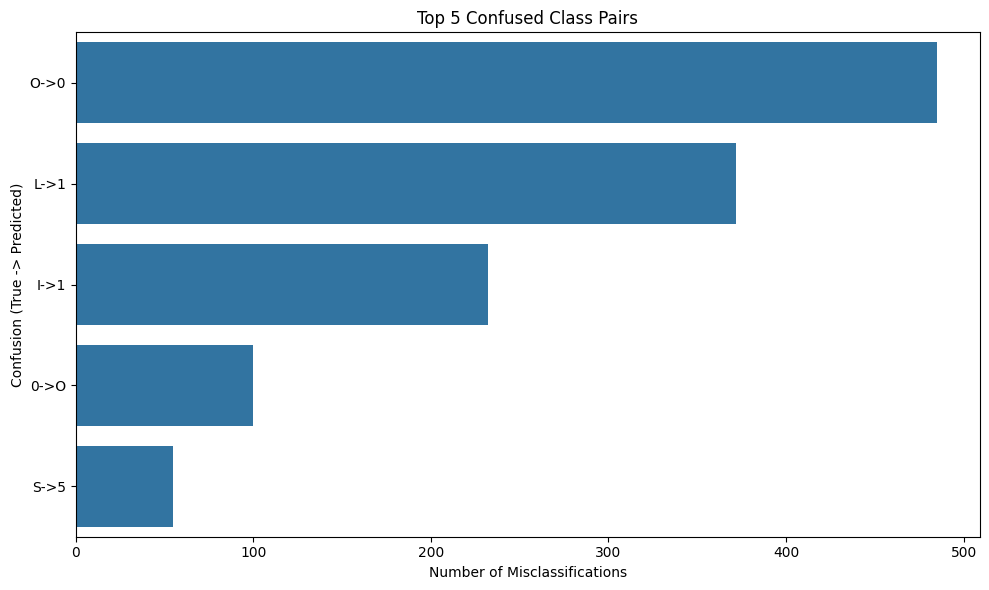




Visualizing misclassified examples for top confused pairs:


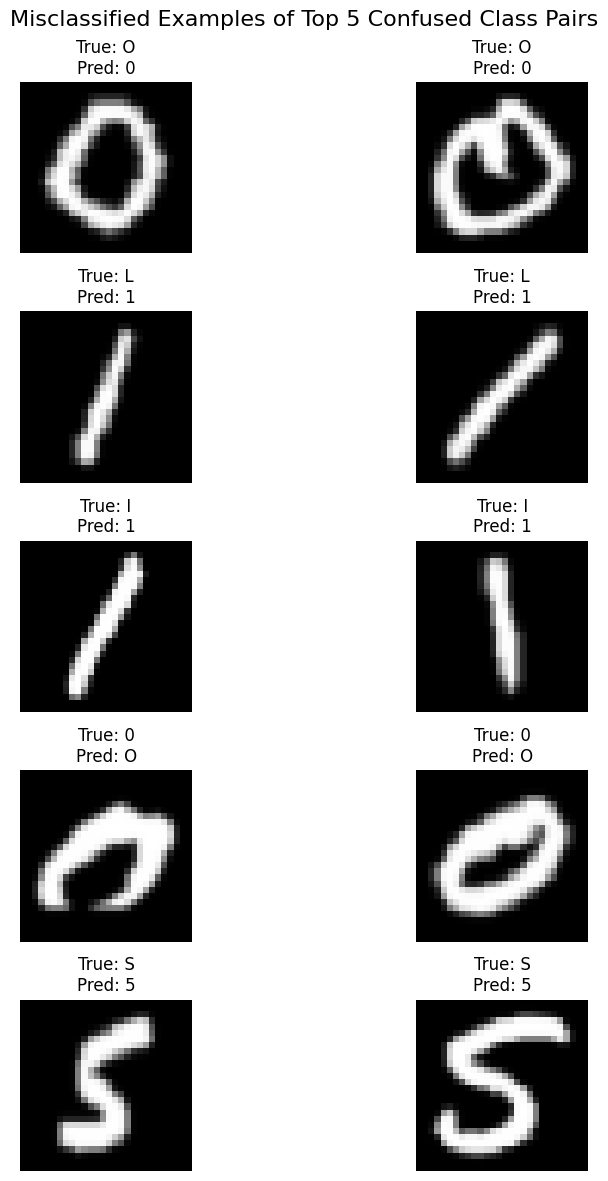




Plotting per-class accuracy (sorted):


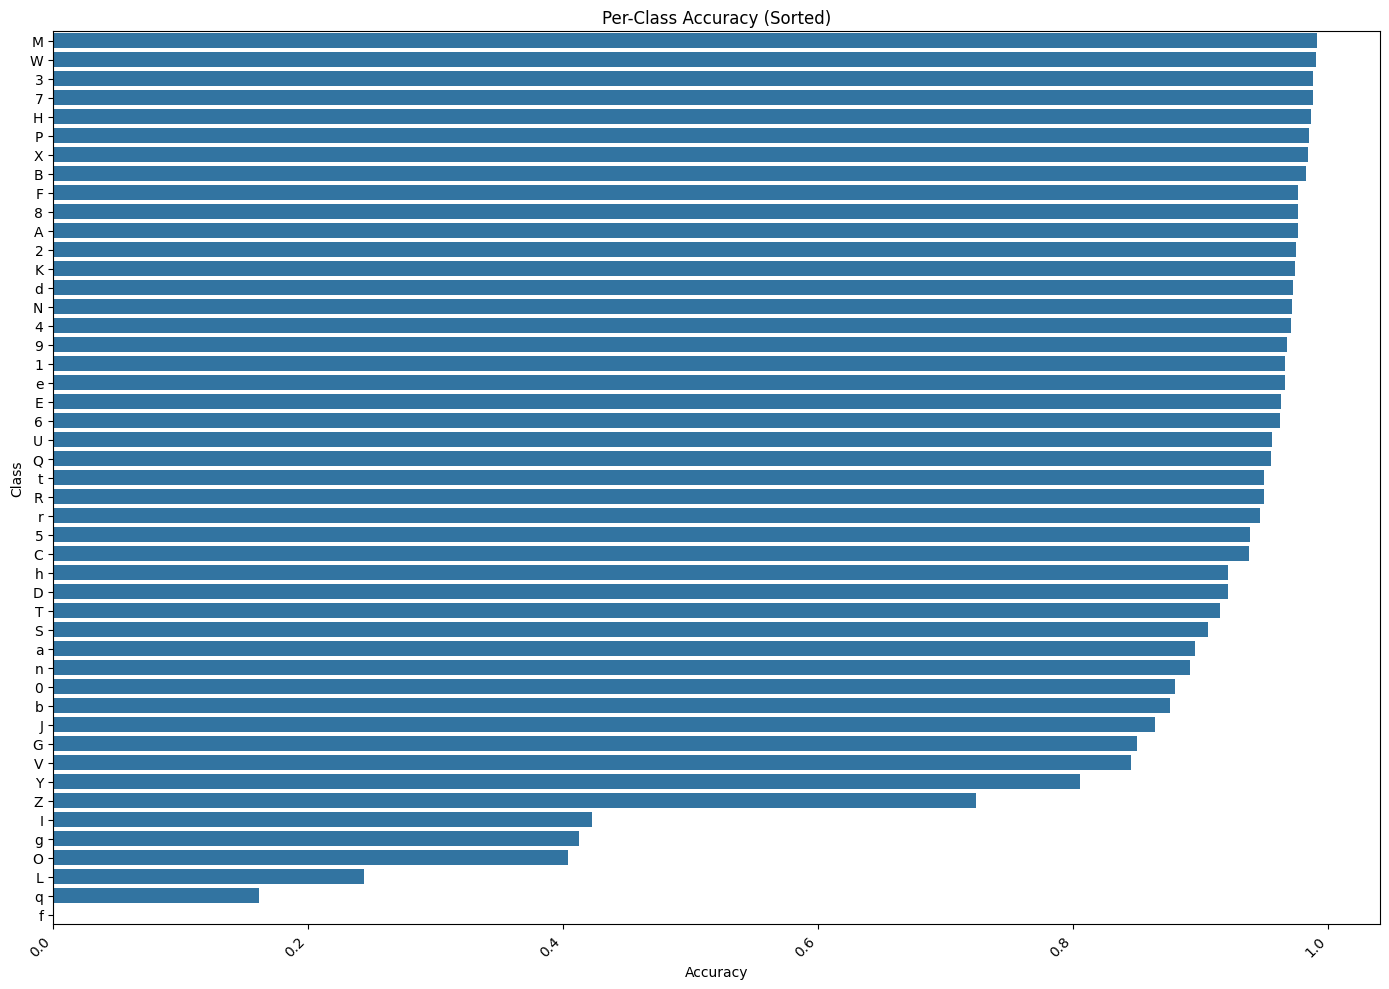

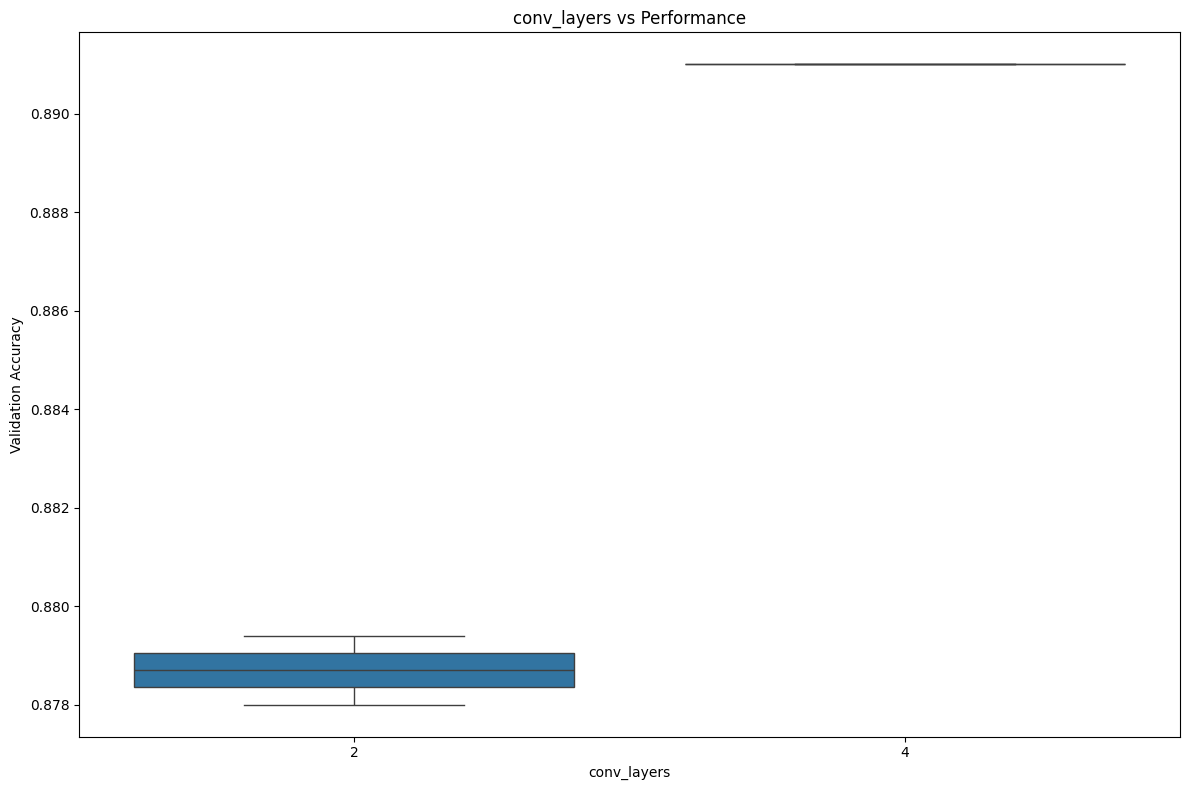




Dot plot for number of dense neurons vs dropout rates:


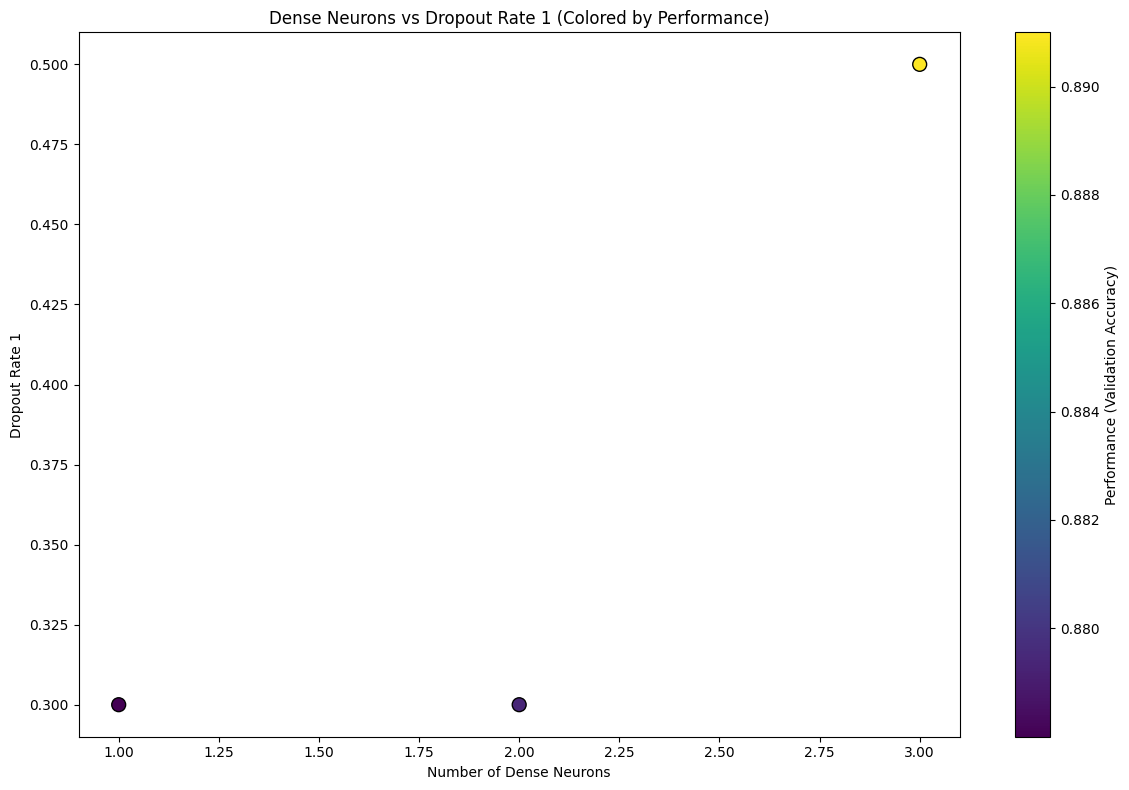




Analyzing interaction between filter grid type and conv_layers:


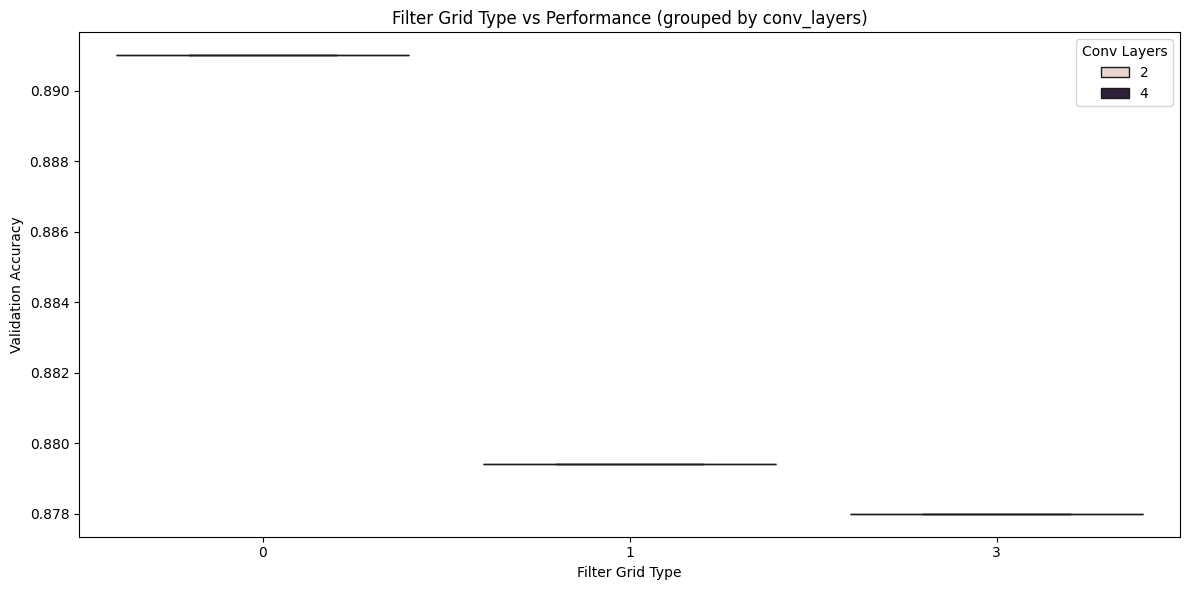





Hyperparameter Importance:
Results summary
Results in kt_search_logs/cnn_hypermodel_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
filter_grid: 0
conv_layers: 4
kernel_size: 1
conv_strides: 0
pool_size: 1
pool_strides: 0
dense_layers: 3
dense_neurons: 256
dropout_rate_1: 0.5
dropout_rate_2: 0.2
dropout_rate_3: 0.3
activation: relu
pooling_frequency: 1
optimizer: rmsprop
learning_rate: 0.001
batch_size: 128
Score: 0.890999972820282

Trial 0 summary
Hyperparameters:
filter_grid: 1
conv_layers: 2
kernel_size: 0
conv_strides: 1
pool_size: 1
pool_strides: 1
dense_layers: 2
dense_neurons: 64
dropout_rate_1: 0.3
dropout_rate_2: 0.0
dropout_rate_3: 0.0
activation: relu
pooling_frequency: 2
optimizer: adam
learning_rate: 0.001
batch_size: 32
Score: 0.8794000148773193

Trial 1 summary
Hyperparameters:
filter_grid: 3
conv_layers: 2
kernel_size: 1
conv_strides: 1
pool_size: 1
pool_strides: 1
dense_layers: 1
dense_neurons: 64
drop

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Evaluate the best model on the test set
start_time = time.time()
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels, batch_size=64)
end_time = time.time()
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Model evaluation time: {end_time - start_time:.4f} seconds")

# Step 2: Measure inference time for predictions
start_time = time.time()
predictions = best_model.predict(test_images)
end_time = time.time()
predicted_labels = np.argmax(predictions, axis=1)
print(f"Inference time for predictions: {end_time - start_time:.4f} seconds")

# Add whitespace between sections for better readability
print("\n\n")


# Step 3: Generate a classification report using the mapped labels
mapped_test_labels = [label_mapping[label] for label in test_labels]
mapped_predicted_labels = [label_mapping[label] for label in predicted_labels]

# Use zero_division=0 to handle undefined precision/recall for classes with no predicted samples
print("\nClassification Report:")
print(classification_report(mapped_test_labels, mapped_predicted_labels, target_names=label_mapping, zero_division=0))

# Add whitespace before plotting confusion matrix
print("\n\n")

# Step 4: Create confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Step 5: Find the top 5 most confused class pairs
confusion_pairs = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j:
            confusion_pairs.append((i, j, cm[i, j]))

confusion_pairs.sort(key=lambda x: x[2], reverse=True)
top_5_confused = confusion_pairs[:5]

# Step 6: Bar chart for top 5 confused pairs
print("\nBar chart for the top 5 confused class pairs:")
top_true_classes = [label_mapping[true_class] for true_class, _, _ in top_5_confused]
top_pred_classes = [label_mapping[pred_class] for _, pred_class, _ in top_5_confused]
top_confusion_counts = [count for _, _, count in top_5_confused]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_confusion_counts, y=[f"{true}->{pred}" for true, pred in zip(top_true_classes, top_pred_classes)])
plt.xlabel("Number of Misclassifications")
plt.ylabel("Confusion (True -> Predicted)")
plt.title("Top 5 Confused Class Pairs")
plt.tight_layout()
plt.show()

print("\n\n")  # Add whitespace after the bar plot

# Step 7: Visualize misclassified examples for each pair
print("Visualizing misclassified examples for top confused pairs:")
num_examples = 2
fig, axes = plt.subplots(len(top_5_confused), num_examples, figsize=(10, 12))
fig.suptitle("Misclassified Examples of Top 5 Confused Class Pairs", fontsize=16)

for idx, (true_class, pred_class, count) in enumerate(top_5_confused):
    true_label = label_mapping[true_class]
    pred_label = label_mapping[pred_class]

    confused_indices = np.where((test_labels == true_class) & (predicted_labels == pred_class))[0]

    for example_idx in range(min(len(confused_indices), num_examples)):
        confused_example = test_images[confused_indices[example_idx]].reshape(28, 28)
        rotated_flipped_example = np.fliplr(np.rot90(confused_example, k=3))

        axes[idx, example_idx].imshow(rotated_flipped_example, cmap='gray')
        axes[idx, example_idx].set_title(f"True: {true_label}\nPred: {pred_label}")
        axes[idx, example_idx].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

print("\n\n")  # Add whitespace before the next plot

# Step 8: Per-Class Accuracy Plot (Sorted and Fixed)
print("Plotting per-class accuracy (sorted):")
per_class_accuracy = np.diag(cm) / np.sum(cm, axis=1)

sorted_indices = np.argsort(per_class_accuracy)[::-1]
sorted_accuracy = per_class_accuracy[sorted_indices]
sorted_labels = [label_mapping[i] for i in sorted_indices]

plt.figure(figsize=(14, 10))  # Larger figure to avoid cramping
sns.barplot(x=sorted_accuracy, y=sorted_labels)
plt.xlabel('Accuracy')
plt.ylabel('Class')
plt.title('Per-Class Accuracy (Sorted)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n\n")  # Add whitespace before the next plot

# Step 9: Hyperparameter Performance Distribution (Improved with focus on one hyperparameter)
important_hps = ['filter_grid', 'conv_layers', 'dense_layers', 'dropout_rate_1', 'learning_rate']
hp_data = {hp: [] for hp in important_hps}
performances = []

for trial in tuner.oracle.trials.values():
    if trial.score is not None:
        for hp in important_hps:
            hp_data[hp].append(trial.hyperparameters.values[hp])
        performances.append(trial.score)

# Now we select one hyperparameter, e.g., 'conv_layers', for detailed analysis
selected_hp = 'conv_layers'

# Plot hyperparameter vs performance
plt.figure(figsize=(12, 8))
sns.boxplot(x=hp_data[selected_hp], y=performances)
plt.xlabel(selected_hp)
plt.ylabel('Validation Accuracy')
plt.title(f'{selected_hp} vs Performance')
plt.tight_layout()
plt.show()

print("\n\n")  # Add whitespace before the next plot

# Step 10: Dot Plot for Multiple Hyperparameters
print("Dot plot for number of dense neurons vs dropout rates:")
plt.figure(figsize=(12, 8))

# Create a dot plot for 'dense_neurons' vs 'dropout_rate_1' as an example
plt.scatter(hp_data['dense_layers'], hp_data['dropout_rate_1'], c=performances, cmap='viridis', edgecolor='k', s=100)

plt.xlabel('Number of Dense Neurons')
plt.ylabel('Dropout Rate 1')
plt.title('Dense Neurons vs Dropout Rate 1 (Colored by Performance)')
plt.colorbar(label='Performance (Validation Accuracy)')
plt.tight_layout()
plt.show()

print("\n\n")  # Add whitespace before the next plot

# Step 11: Analyze interaction between filter grid type and conv_layers (if applicable)
print("Analyzing interaction between filter grid type and conv_layers:")
plt.figure(figsize=(12, 6))

sns.boxplot(x=hp_data['filter_grid'], y=performances, hue=hp_data['conv_layers'])
plt.xlabel('Filter Grid Type')
plt.ylabel('Validation Accuracy')
plt.title('Filter Grid Type vs Performance (grouped by conv_layers)')
plt.legend(title='Conv Layers')
plt.tight_layout()
plt.show()

print("\n\n")  # Add whitespace after all plots

# If available, print hyperparameter importance summary from Tuner
if hasattr(tuner, 'results_summary'):
    print("\nHyperparameter Importance:")
    tuner.results_summary()

